# Setting up the environment

In [1]:
import sys
import os

os.path.dirname(sys.executable)

'c:\\Users\\Sanhoj\\projects\\deepweeds_computervision\\venv\\Scripts'

In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
import math

print(tf.__version__)

2.4.0


In [3]:
# loading tensorboard
%load_ext tensorboard

%matplotlib inline
# plt.rcParams['figure.figsize'] = [16, 8]

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Splitting the dataset

In [5]:
# all dataset is in one split called train with 17509 images.
# we split as in the paper 60% - 20% - 20% , Training - Validation - Test.
# the following lignes of code do exactly that.

data_train, train_info = tfds.load("deep_weeds", with_info=True, split='train[0%:60%]')
data_valid, val_info  = tfds.load("deep_weeds", with_info=True, split='train[60%:80%]')
data_test, test_info = tfds.load("deep_weeds", with_info=True, split='train[80%:100%]')

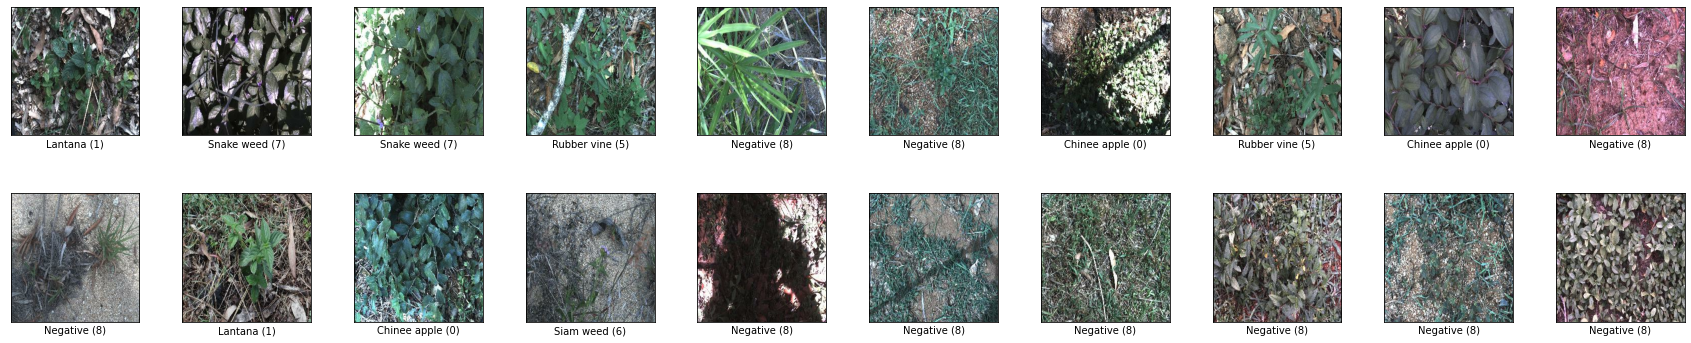

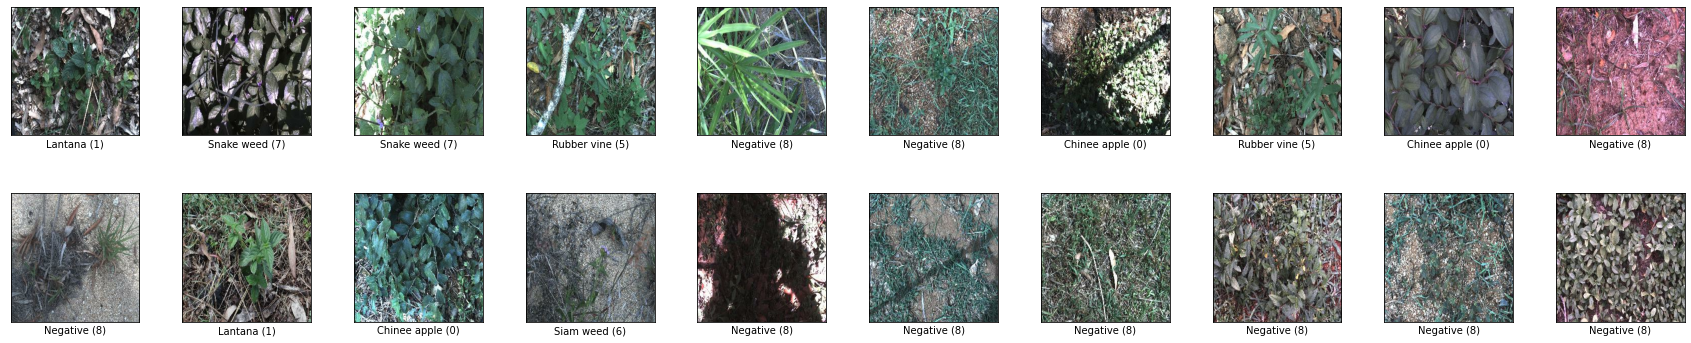

In [6]:
# A preview of the images in the dataset

tfds.show_examples(data_train, train_info, rows=2, cols=10)

In [7]:
# taking one example from the training dataset!
# we print the shape of the image

list(data_train.take(1))[0]['image'].shape

TensorShape([256, 256, 3])

# Augmenting the data 

In [8]:
import numpy as np

def preprocess_weeds(dic):
  '''
  preprocessing of images
  Args:
    Dict: image, label
  Returns:
    resized image and scaled
  '''

  image = dic['image']
  # Scale to between 0 and 1 & resize to 224 for resnet-50 input
  preprocessed_image = tf.image.resize(image, [224, 224])/255
  label = dic['label']
  return preprocessed_image, label


def zoom(x: tf.Tensor) -> tf.Tensor:
    '''
    Zoom augmentation
    Args:
        x: Image
    Returns:
        Augmented image
    '''

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(img, boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]
  
    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))


def augment(image, label):
  '''
    this augmentor simulates the series of augmentation made in the paper!
    + random rotation
    +
  '''
 
  # image = zoom([image])
  # Random brightness
  image = tf.image.random_brightness(image, max_delta=0.5)
  # random hoeizontal flip
  image = tf.image.random_flip_left_right(image)
  # random vertical flip
  image = tf.image.random_flip_up_down(image)
  # random shiffting of the channels
  image = tf.image.random_hue(image, max_delta=0.1)
  # Adjust contrast
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
  #random rotation
  delta = tf.random.uniform([], minval = math.radians(-360), maxval = math.radians(360), dtype=tf.float32)
  image = tf.image.rot90(image, tf.dtypes.cast(delta, tf.int32))
  return image, label

# Use the batch method to prepare batches.
data_train_gen = (data_train
                  .map(preprocess_weeds)
                  .cache()
                  .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .batch(32)
                  .prefetch(tf.data.experimental.AUTOTUNE))

data_valid_gen = data_valid.map(preprocess_weeds).cache().batch(32)
data_test_gen = data_test.map(preprocess_weeds).cache().batch(32)

# Building and compiling the model

In [9]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9)

image_input = Input((224, 224, 3))
resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")

NUM_CLASSES=9
model = tf.keras.Sequential(
    [image_input,
     resnet,
     AveragePooling2D(),
     Flatten(),
     Dense(NUM_CLASSES, activation="softmax")])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss="sparse_categorical_crossentropy", metrics="accuracy")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 9)                 165897    
Total params: 23,753,609
Trainable params: 23,700,489
Non-trainable params: 53,120
_________________________________________________________________


# Training the model

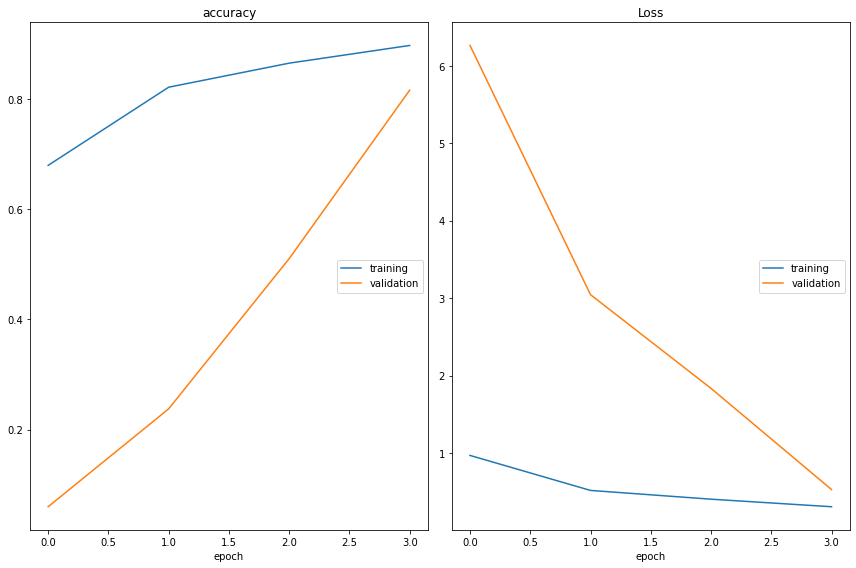

accuracy
	training         	 (min:    0.680, max:    0.898, cur:    0.898)
	validation       	 (min:    0.060, max:    0.817, cur:    0.817)
Loss
	training         	 (min:    0.306, max:    0.969, cur:    0.306)
	validation       	 (min:    0.528, max:    6.263, cur:    0.528)

Epoch 00004: saving model to Checkpoint\model_0.h5
Wall time: 7min 16s


In [11]:
%%time

from tensorflow.keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras
import datetime

check_path = "Checkpoint/model_0.h5"

checkpoint = ModelCheckpoint(check_path, monitor='val_accuracy', mode='max', verbose=2)

my_callbacks = [PlotLossesKeras(), checkpoint]

model.fit(x=data_train_gen,
          epochs=4,
          batch_size=2048,
          validation_data=data_valid_gen,
          callbacks=my_callbacks)

In [12]:
# go to the command line and run
# tensorboard --logdir logs/fit
# to launch tensorboard

# Model evaluation

In [12]:
# predict test dataset
predictions = model.predict(data_test_gen)

# predicted ones
val_preds = np.argmax(predictions, axis=1)

# true ones
val_trues = np.array([label["label"].numpy() for _, label in enumerate(data_test)])

weeds_label = ["Chinee apple", "Lantana", "Parkinsonia", "Parthenium", "Prickly acacia", "Rubber vine", "Siam weed", "Snake weed", "Negatives"]

In [13]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot
    Arguments
    ---------------------------------------------------------------------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix
    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']
    title:        the text to display at the top of the matrix
    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1-accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

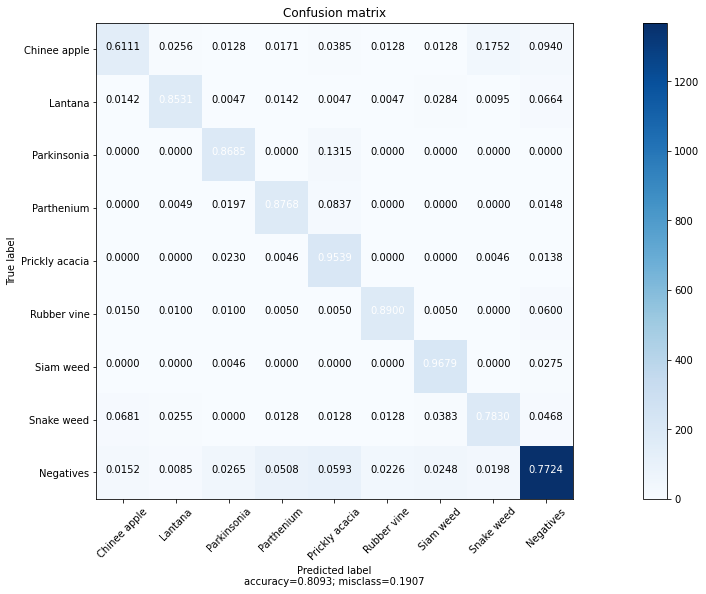

In [14]:
plot_confusion_matrix(cm=confusion_matrix(val_trues, val_preds), target_names=weeds_label, normalize=True)

In [15]:
print(classification_report(val_trues, val_preds, target_names=weeds_label))

                precision    recall  f1-score   support

  Chinee apple       0.74      0.61      0.67       234
       Lantana       0.86      0.85      0.86       211
   Parkinsonia       0.75      0.87      0.80       213
    Parthenium       0.64      0.88      0.74       203
Prickly acacia       0.56      0.95      0.70       217
   Rubber vine       0.79      0.89      0.84       200
     Siam weed       0.77      0.97      0.86       218
    Snake weed       0.70      0.78      0.74       235
     Negatives       0.95      0.77      0.85      1771

      accuracy                           0.81      3502
     macro avg       0.75      0.84      0.78      3502
  weighted avg       0.84      0.81      0.81      3502



# Thank you